In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.python.client import device_lib


/Users/samcohen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())




config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("----------------------------")
print
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17508758573287366066
]
----------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5003565316840347572
]


# TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* 


## Generate sine wave data points

In [5]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.1

#points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
#data = [np.sin(i) for i in np.arange(start=0, stop=num_cycles*2*np.pi, step=sample_rate)]

#print("Total data points: " + str(len(data)))

#Get the number of points for a clean multiple of some batch size
# print(int(len(data)/4))
# print(int(len(data)/4) * 4)
#batch_size = 4

dataframe = pd.read_excel('../../data/130N_Cycles_1-47.xlsx')



In [41]:
df = dataframe.drop('time', 1)


#Store as a numpy ndarray
data = df.values
data = data.astype('float32')


#div_variable = 2



#Take second half of the data
#data_index = int(len(data)/div_variable)



#data = data[:-int(len(data)/3)]
#Undersample
data = data[0::50]
print("final data length: " + str(len(data)))


num_cycles = int(47)
print("num_cycles: " + str(num_cycles))

points_per_cycle = int(len(data)/num_cycles)
print("Points per cycle: " + str(points_per_cycle))







final data length: 3403
num_cycles: 47
Points per cycle: 72


## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [42]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    print("in series_to_examples")
    print(final.shape)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    print("in prepare_data")
    print(df_train.shape)
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [43]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 5
n_forecast = int(points_per_cycle*1.5)
# n_prev = 300
# n_forecast = 65
# print(n_prev)
# print(n_forecast)

#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast# int(len(data)*0.2)

#batch_size = 4

train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

#train = train[112:]
print(n_forecast)

in series_to_examples
(2468, 468)
in prepare_data
(2468, 468)
108


## Visualize total dataset and goal in red

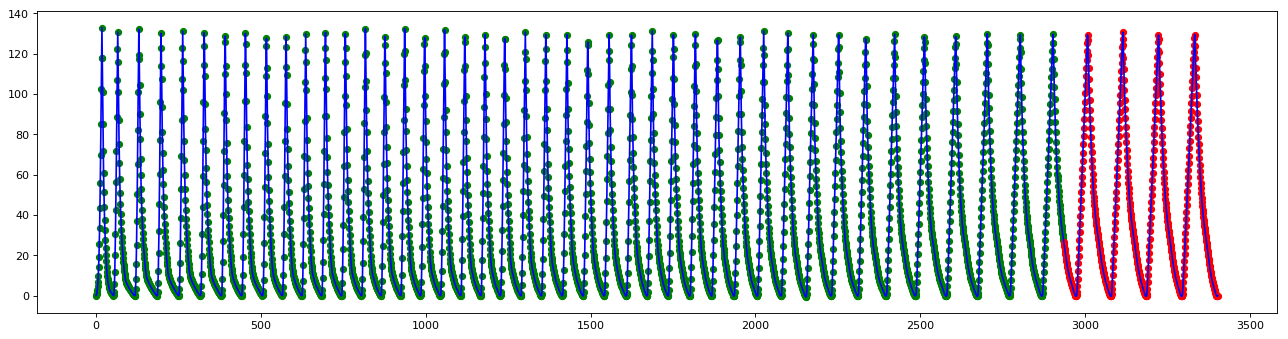

In [44]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Plot the original data using the defined train and test sizes
train_plot, test_plot = data[:-n_test], data[-n_test:]

#Line plot along the true data
plt.plot(data, color="blue")

#Plot the training points in green
train_plot_x = [x for x in range(len(train_plot))]
plt.scatter(train_plot_x, train_plot, color="green", s=30)

#Note: we have to shift the test data to plot it
test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [45]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    #y = y.reshape(1, y.shape[0])
    
    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    architecture += "LSTM; "
    model.add(Dense(180))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    
    
    
    #Fit the network to the training data
    for i in range(nb_epoch):
        print(i)
        
        start = timer()
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
        end = timer()
        print("Epoch duration: " + str(end - start))
    return model, architecture

In [47]:
print(train.shape)
train = train[68:]
print(train.shape)

(2468, 468)
(2400, 468)


## Train the Neural Network

In [48]:
n_epochs = 500
n_batch = 200
n_neurons = 200
print(len(train))
print(train.shape)
model, architecture = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


2400
(2400, 468)
X shape: (2400, 360)
y shape: (2400, 108)
(200, 360, 1)
(2400, 360, 1)
0
Epoch duration: 21.084199034994526
1
Epoch duration: 20.590806441003224
2
Epoch duration: 18.536983013997087
3
Epoch duration: 18.47162695800216
4
Epoch duration: 21.15738675200555
5
Epoch duration: 23.419856958993478
6
Epoch duration: 22.17324146500323
7
Epoch duration: 21.61338916599925
8
Epoch duration: 23.197550703996967
9
Epoch duration: 20.464385291998042
10
Epoch duration: 20.42302595199726
11
Epoch duration: 20.63388343299448
12
Epoch duration: 20.518995165002707
13
Epoch duration: 20.978472602000693
14
Epoch duration: 20.539508235997346
15
Epoch duration: 20.306918395006505
16
Epoch duration: 21.010966569003358
17
Epoch duration: 20.453252024002722
18
Epoch duration: 23.21547466699849
19
Epoch duration: 20.276812894000614
20
Epoch duration: 20.345513195999956
21
Epoch duration: 20.4731647899971
22
Epoch duration: 23.596903079000185
23
Epoch duration: 24.60834505099774
24
Epoch duration: 2

KeyboardInterrupt: 

In [67]:
def forecast_lstm(model, X, n_batch):
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [68]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
print(len(test_x))
y_hat = forecast_lstm(model, test_x, n_batch)
print("First true label: " + str(test_y[0]))
print("First forecast: " +str(y_hat[0]))

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("Average RMSE: ")
print(sum(RMSE)/len(RMSE))

400
(200, 400, 1)
First true label: [2.95122]
First forecast: 5.268999
Average RMSE: 
29.234343683174036


## Evaluate the forecast based on its RMSE and record results

In [69]:
#Evaluate forecasts and record them in a text file
from sklearn.metrics import mean_squared_error
import math

RMSE = []
for i in range(n_forecast):
    RMSE.append(math.sqrt(mean_squared_error(test_y, y_hat)))
print("RMSE: ")
print(RMSE)

#Open the textfile to append to
text_file = open("results.txt", "a")

text_file.write("\n\nNEW TRIAL: \n\n")
text_file.write("Architecture: " + str(architecture)+"\n")
text_file.write("Epochs: " + str(n_epochs)+"\n")
text_file.write("Average RMSE: " + str(sum(RMSE)/len(RMSE))+"\n")
text_file.write("Average predicted value: " + str(sum(y_hat)/len(y_hat))+"\n")
text_file.write("Variance of predicted values: " + str(np.var(y_hat))+"\n")
text_file.write("Min: " + str(min(y_hat))+ " Max: " +str(max(y_hat)) + "\n")


#Close the file after writing results to it
text_file.close()


RMSE: 
[29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683174032, 29.234343683

## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

y size: 80
x size: 80
400
400
Epochs: 600
Average RMSE: 29.234343683174036
Average predicted value: 41.03840552428737
Variance of predicted values: 1404.0339
Min: -0.57675344 Max: 117.75092


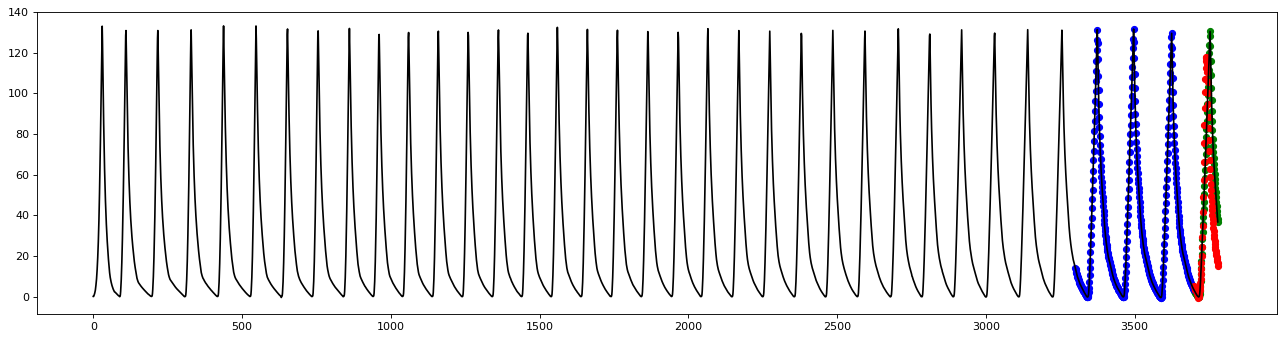

In [70]:
#Display forecasts

#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#data = data[:int(len(data)/2)]
plt.plot(data, color="black")



xs = [x for x in range(len(data))]
#plt.scatter(xs, data, color="blue", s = 15)






#Define indices for which to plot the prediction
index_start = len(data) - len(y_hat)
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]

#print(len(test_y))
#print(len(y_hat))
#print(len(labels_x))
#mod_data = [y+ for y in data[-40:]]
#fake_y = [y for y in range()]



#Display true labels in green
#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

print("y size: " +str(len(y_hat)))
print("x size: " +str(len(labels_x)))


#Display the X of that this prediction was based on
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)
test_x_indices = [x for x in range(test_x_start, test_x_end)]

test_x_labels = [data[y] for y in test_x_indices]

print(len(test_x_indices))
print(len(test_x_labels))

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)

#Display forecasted labels in red
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]
plt.scatter(labels_x, y_hat, color="red", s=30)

print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(sum(RMSE)/len(RMSE)))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))